
### What's different here:
* Data frames are made differently here (e.g. average rating no longer takes zero-ratings into account)
* __averageRatingdf__ is now called __books_rated__
* __ratings__ is now called __readers_15plus__
* __books_ratings__ has all the ratings aggregated in the new columns, so no user_id, and is saved to books_rated.csv
* __books_users_ratings__ has all the aggregated ratings columns as well as user_id and individual ratings, saved to books_users_ratings.csv
* __books_rated__ is then joined again with __ratings__ (right join) to have all the info needed for collaborative filtering

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sklearn
# import pickleshare as ps

In [156]:
# %run import_data

Continuing with existing version of data folder
Goodreads dataset loaded successfully as books_goodreads
Pandas dataframes (books_goodreads, books_big, book, users, ratings) loaded successfully
Columns in DataFrames 'users' and 'ratings' renamed
You can use the DataFrames 'books' or 'books_big' - they are exactly the same (big) dataset
Ready to go!


In [158]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l,genre
0,590085417,Heidi,Johanna Spyri,2021,Scholastic,http://images.amazon.com/images/P/0590085417.0...,http://images.amazon.com/images/P/0590085417.0...,http://images.amazon.com/images/P/0590085417.0...,"Johanna Spyri, Shirley Temple, Movie tie-in, C..."
1,068160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,http://images.amazon.com/images/P/068160204X.0...,http://images.amazon.com/images/P/068160204X.0...,http://images.amazon.com/images/P/068160204X.0...,NaN
2,068107468X,Edgar Allen Poe Collected Poems,Edgar Allan Poe,2020,Bausch & Lombard,http://images.amazon.com/images/P/068107468X.0...,http://images.amazon.com/images/P/068107468X.0...,http://images.amazon.com/images/P/068107468X.0...,American Fantasy poetry
3,307124533,Owl's Amazing but True No. 2,Owl Magazine,2012,Golden Books,http://images.amazon.com/images/P/0307124533.0...,http://images.amazon.com/images/P/0307124533.0...,http://images.amazon.com/images/P/0307124533.0...,NaN
4,380816792,A Rose in Winter,Kathleen E. Woodiwiss,2011,Harper Mass Market Paperbacks,http://images.amazon.com/images/P/0380816792.0...,http://images.amazon.com/images/P/0380816792.0...,http://images.amazon.com/images/P/0380816792.0...,"Fiction, Historical Fiction, Romance, Fiction,..."


### Cleaning 'isbn' before merging books with ratings
(This is so that the merge successfully finds 917916 matching rows instead of only 183600)

In [115]:
# Function to remove leading zeros from ISBNs
def remove_leading_zeros(isbn):
    return isbn.lstrip('0') if isbn else isbn

# Apply the function to both DataFrames
books['isbn'] = books['isbn'].astype(str).apply(remove_leading_zeros)
ratings['isbn'] = ratings['isbn'].astype(str).apply(remove_leading_zeros)

# Now perform the join
books_users_ratings = books.merge(ratings, on='isbn', how='left')


In [116]:
books_users_ratings.isbn.nunique()

226493

In [117]:
# merge books with ratings df
# books_ratings = pd.merge(books_big, ratings, on='isbn', how='left')
books_users_ratings.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l,genre,user_id,book_rating
0,590085417,Heidi,Johanna Spyri,2021,Scholastic,http://images.amazon.com/images/P/0590085417.0...,http://images.amazon.com/images/P/0590085417.0...,http://images.amazon.com/images/P/0590085417.0...,"Johanna Spyri, Shirley Temple, Movie tie-in, C...",102967.0,8.0
1,590085417,Heidi,Johanna Spyri,2021,Scholastic,http://images.amazon.com/images/P/0590085417.0...,http://images.amazon.com/images/P/0590085417.0...,http://images.amazon.com/images/P/0590085417.0...,"Johanna Spyri, Shirley Temple, Movie tie-in, C...",111702.0,8.0
2,590085417,Heidi,Johanna Spyri,2021,Scholastic,http://images.amazon.com/images/P/0590085417.0...,http://images.amazon.com/images/P/0590085417.0...,http://images.amazon.com/images/P/0590085417.0...,"Johanna Spyri, Shirley Temple, Movie tie-in, C...",135473.0,0.0
3,68160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,http://images.amazon.com/images/P/068160204X.0...,http://images.amazon.com/images/P/068160204X.0...,http://images.amazon.com/images/P/068160204X.0...,NaN,16634.0,0.0
4,68160204X,The Royals,Kitty Kelley,2020,Bausch & Lombard,http://images.amazon.com/images/P/068160204X.0...,http://images.amazon.com/images/P/068160204X.0...,http://images.amazon.com/images/P/068160204X.0...,NaN,87141.0,0.0


In [118]:
books_users_ratings.shape

(982098, 11)

In [119]:
books_users_ratings.isna().sum()

isbn                       0
book_title                 0
book_author              291
year_of_publication        0
publisher                  0
image_url_s                0
image_url_m                0
image_url_l                0
genre                  63767
user_id                  238
book_rating              238
dtype: int64

In [120]:
books_users_ratings.dropna(subset=['user_id', 'book_author', 'genre'], inplace=True) 
# drop rows with missings in important columns for our recommender

In [121]:
books_users_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 917916 entries, 0 to 982096
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 917916 non-null  object 
 1   book_title           917916 non-null  object 
 2   book_author          917916 non-null  object 
 3   year_of_publication  917916 non-null  int64  
 4   publisher            917916 non-null  object 
 5   image_url_s          917916 non-null  object 
 6   image_url_m          917916 non-null  object 
 7   image_url_l          917916 non-null  object 
 8   genre                917916 non-null  object 
 9   user_id              917916 non-null  float64
 10  book_rating          917916 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 84.0+ MB


In [122]:
# In the original notebook, books_ratings was only able to find 
# 183600 rows where books and ratings match on isbn
# This is possibly due to leading zeros in many isbn's in one df,
# but not in the other
#
# In the original notebook, this is the output for
# books_ratings.info()
# 
# # Index: 183600 entries, 1 to 350153
# Data columns (total 8 columns):
#  #   Column               Non-Null Count   Dtype 
# ---  ------               --------------   ----- 
#  0   isbn                 183600 non-null  object
#  1   book_title           183600 non-null  object
#  2   book_author          183537 non-null  object
#  3   year_of_publication  183600 non-null  int64 
#  4   publisher            183600 non-null  object
#  5   genre                152371 non-null  object
#  6   user_id              183600 non-null  int64 
#  7   book_rating          183600 non-null  int64 

In [124]:
# Now let's create a data frame containing only the books,
# their respective info and their aggregated popularity functions
# These functions are avg_rating (mean of non-zero ratings)
# and readers (simple count of all readers per book)
# This is based on the info that book_rating = 0
# means the user acquired the book but never rated it
# So from our stakeholder's point of view, a zero rating
# is still a sale, albeit one with no particular feedback


# Create the dataset blueprint by copying books_users_ratings:
books_ratings = books_users_ratings.copy()

# Add empty columns 'readers' and 'avg_rating'
books_ratings['readers'] = np.nan
books_ratings['avg_rating'] = np.nan
books_ratings['active_ratings'] = np.nan


# Custom function to calculate mean of non-zero ratings
def mean_non_zero(series):
    non_zero_ratings = series[series != 0]  # Filter out zero ratings
    return non_zero_ratings.mean() if len(non_zero_ratings) > 0 else 0

# Custom function to count non-zero ratings
def count_non_zero(series):
    non_zero_ratings = series[series != 0]  # Filter out zero ratings
    return non_zero_ratings.count() if len(non_zero_ratings) > 0 else 0

# Group by 'isbn' and apply aggregation
books_ratings = books_ratings.groupby('isbn').agg(
    book_title=('book_title', 'first'),
    book_author=('book_author', 'first'),
    year_of_publication=('year_of_publication', 'first'),
    publisher=('publisher', 'first'),
    image_url_s=('image_url_s', 'first'),
    image_url_m=('image_url_m', 'first'),
    image_url_l=('image_url_l', 'first'),
    genre=('genre', 'first'),
    readers=('book_rating', 'count'),  # Count of non-null values in 'book_rating'
    active_ratings=('book_rating', count_non_zero),  # Mean of non-zero values
    avg_rating=('book_rating', mean_non_zero)  # Mean of non-zero values
).reset_index()

books_ratings.head()


,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l,genre,readers,active_ratings,avg_rating
0,1010565,Mog's Christmas,Judith Kerr,1992,Collins,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,"Children's fiction, Cats, fiction, Christmas, ...",2,0,0.0
1,1046438,Liar,Stephen Fry,1970,Harpercollins Uk,http://images.amazon.com/images/P/0001046438.0...,http://images.amazon.com/images/P/0001046438.0...,http://images.amazon.com/images/P/0001046438.0...,"Truthfulness and falsehood, Fiction, Murder, I...",1,1,9.0
2,1046713,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,"Biographies, Biography, Childhood and youth, E...",1,0,0.0
3,1046934,The Prime of Miss Jean Brodie,Muriel Spark,1999,Trafalgar Square Publishing,http://images.amazon.com/images/P/0001046934.0...,http://images.amazon.com/images/P/0001046934.0...,http://images.amazon.com/images/P/0001046934.0...,"Teacher-student relationships, Women teachers,...",1,0,0.0
4,1047213,The Fighting Man,Gerald Seymour,1993,HarperCollins Publishers,http://images.amazon.com/images/P/0001047213.0...,http://images.amazon.com/images/P/0001047213.0...,http://images.amazon.com/images/P/0001047213.0...,"Fiction, thrillers, suspense, Fiction, thrille...",1,1,9.0


In [125]:
books_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195390 entries, 0 to 195389
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 195390 non-null  object 
 1   book_title           195390 non-null  object 
 2   book_author          195390 non-null  object 
 3   year_of_publication  195390 non-null  int64  
 4   publisher            195390 non-null  object 
 5   image_url_s          195390 non-null  object 
 6   image_url_m          195390 non-null  object 
 7   image_url_l          195390 non-null  object 
 8   genre                195390 non-null  object 
 9   readers              195390 non-null  int64  
 10  active_ratings       195390 non-null  int64  
 11  avg_rating           195390 non-null  float64
dtypes: float64(1), int64(3), object(8)
memory usage: 17.9+ MB


In [126]:
books_ratings.isna().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
image_url_s            0
image_url_m            0
image_url_l            0
genre                  0
readers                0
active_ratings         0
avg_rating             0
dtype: int64

In [127]:
books_ratings.duplicated().sum()

0

In [128]:
books_ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
year_of_publication,195390.0,1993.619085,8.409454,1900.0,1989.0,1996.0,2000.0,2021.0
readers,195390.0,4.697866,16.078477,1.0,1.0,2.0,4.0,2504.0
active_ratings,195390.0,1.760059,6.672956,0.0,0.0,1.0,1.0,707.0
avg_rating,195390.0,4.570947,3.904373,0.0,0.0,6.0,8.0,10.0


In [129]:
books_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195390 entries, 0 to 195389
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 195390 non-null  object 
 1   book_title           195390 non-null  object 
 2   book_author          195390 non-null  object 
 3   year_of_publication  195390 non-null  int64  
 4   publisher            195390 non-null  object 
 5   image_url_s          195390 non-null  object 
 6   image_url_m          195390 non-null  object 
 7   image_url_l          195390 non-null  object 
 8   genre                195390 non-null  object 
 9   readers              195390 non-null  int64  
 10  active_ratings       195390 non-null  int64  
 11  avg_rating           195390 non-null  float64
dtypes: float64(1), int64(3), object(8)
memory usage: 17.9+ MB


In [131]:
books_ratings = books_ratings.sort_values(by=['readers','active_ratings', 'avg_rating'], ascending=[False, False, False])

In [132]:
books_ratings.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l,genre,readers,active_ratings,avg_rating
194925,971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,"Fiction, Spiritual life, Metaphysics, Adventur...",2504,581,4.390706
44934,316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,"Murder, Psychological fiction, Teenage girls, ...",1295,707,8.185290
73823,385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,"Suspense & Thriller, Spiritual Fiction, hieros...",885,489,8.437628
122481,60928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,"Fiction, Literature, Conflict of generations, ...",732,320,7.887500
39439,312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,"Women in the Bible, Fiction, Religious fiction...",724,384,8.182292


In [133]:
books_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195390 entries, 194925 to 195388
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 195390 non-null  object 
 1   book_title           195390 non-null  object 
 2   book_author          195390 non-null  object 
 3   year_of_publication  195390 non-null  int64  
 4   publisher            195390 non-null  object 
 5   image_url_s          195390 non-null  object 
 6   image_url_m          195390 non-null  object 
 7   image_url_l          195390 non-null  object 
 8   genre                195390 non-null  object 
 9   readers              195390 non-null  int64  
 10  active_ratings       195390 non-null  int64  
 11  avg_rating           195390 non-null  float64
dtypes: float64(1), int64(3), object(8)
memory usage: 19.4+ MB


In [134]:
books_ratings.to_csv('data/books_rated.csv', sep=';', encoding='utf-8-sig', index=False)

In [135]:
books_ratings = pd.read_csv('data/books_rated.csv', sep=";", encoding='utf-8-sig')

In [136]:
books_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195390 entries, 0 to 195389
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 195390 non-null  object 
 1   book_title           195390 non-null  object 
 2   book_author          195390 non-null  object 
 3   year_of_publication  195390 non-null  int64  
 4   publisher            195390 non-null  object 
 5   image_url_s          195390 non-null  object 
 6   image_url_m          195390 non-null  object 
 7   image_url_l          195390 non-null  object 
 8   genre                195390 non-null  object 
 9   readers              195390 non-null  int64  
 10  active_ratings       195390 non-null  int64  
 11  avg_rating           195390 non-null  float64
dtypes: float64(1), int64(3), object(8)
memory usage: 17.9+ MB


### Creating 'mod_titles' for Search Engine

In [137]:
books_ratings["mod_titles"] = books_ratings['book_title'].str.replace("[^a-zA-Z0-9]", " ", regex=True)    #removing special characters from book titles   
books_ratings.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l,genre,readers,active_ratings,avg_rating,mod_titles
0,971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,"Fiction, Spiritual life, Metaphysics, Adventur...",2504,581,4.390706,Wild Animus
1,316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,"Murder, Psychological fiction, Teenage girls, ...",1295,707,8.185290,The Lovely Bones A Novel
2,385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,"Suspense & Thriller, Spiritual Fiction, hieros...",885,489,8.437628,The Da Vinci Code
3,60928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,"Fiction, Literature, Conflict of generations, ...",732,320,7.887500,Divine Secrets of the Ya Ya Sisterhood A Novel
4,312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,"Women in the Bible, Fiction, Religious fiction...",724,384,8.182292,The Red Tent Bestselling Backlist


In [138]:
books_ratings['mod_titles'] = books_ratings['mod_titles'].str.lower()    #converting book titles to lowercase
books_ratings['mod_titles'] = books_ratings['mod_titles'].str.replace('\s+', ' ', regex=True)    #removing extra spaces from book titles
books_ratings = books_ratings[books_ratings['mod_titles'].str.len() > 0]    #removing rows with empty book titles

In [139]:
#saving the average rating dataframe to a csv file'
books_ratings.to_csv('data/books_rated.csv', sep=';', encoding='utf-8-sig', index=False)

In [141]:
books_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195390 entries, 0 to 195389
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 195390 non-null  object 
 1   book_title           195390 non-null  object 
 2   book_author          195390 non-null  object 
 3   year_of_publication  195390 non-null  int64  
 4   publisher            195390 non-null  object 
 5   image_url_s          195390 non-null  object 
 6   image_url_m          195390 non-null  object 
 7   image_url_l          195390 non-null  object 
 8   genre                195390 non-null  object 
 9   readers              195390 non-null  int64  
 10  active_ratings       195390 non-null  int64  
 11  avg_rating           195390 non-null  float64
 12  mod_titles           195390 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 19.4+ MB


In [77]:
books_sorted_readers = books_ratings.sort_values(by='readers', ascending=False)

In [44]:
# # Plot the top rated books  with the highest rating count   
# sns.barplot(x='mod_titles', y='readers', hue='avg_rating', data=books_sorted_readers, palette='viridis')
# # plt.xticks(rotation=90)

In [28]:
#books_ratings.drop('user_id', axis=1, inplace=True)   #dropping user_id column

In [78]:
books_ratings.duplicated().sum()

0

In [79]:
books_ratings.readers.describe()

count    195390.000000
mean          4.697866
std          16.078477
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        2504.000000
Name: readers, dtype: float64

<Axes: ylabel='readers'>

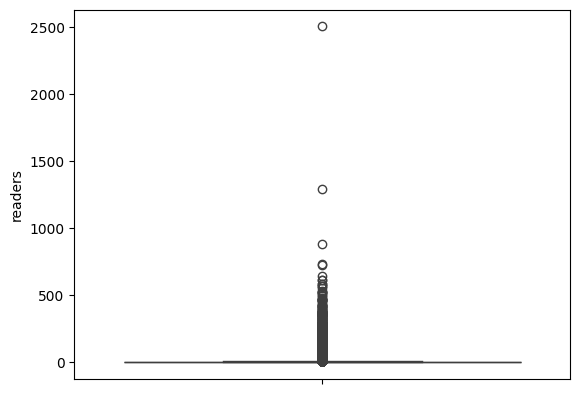

In [80]:
sns.boxplot(books_ratings.readers)

In [142]:
books_ratings['mod_titles'].nunique()

171073